<a href="https://colab.research.google.com/github/Yuan-Yu-Han/PTAS/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Using Transformer Network
Training a transformer model to forecast time series sequence of stock closing price  
Using 10 timesteps to forecast 1 forward timestep

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Time-Series-Forecasting-main'
!ls

Mounted at /content/drive
/content/drive/MyDrive/Time-Series-Forecasting-main
data  images  LICENSE  model  README.md  requirements.txt  src


# 1. Definition

### 1.1. Import Libraries

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt

### 1.2. Load dataset and set global variables

In [ ]:
input_window = 10 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 250

# check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("your device is: ", device)

# read facebook dataset
df = pd.read_csv("data/facebook.csv")
df.head()

your device is:  cuda


,date,minute,label,high,low,open,close,average,volume,notional,...,rsi,long,exit_long,short,exit_short,long_pnl,short_pnl,total_pnl,long_labels,short_labels
0,2019-04-01,09:30,09:30 AM,168.000,167.52,167.925,167.82,167.775,9294.0,1559300.720,...,NaN,NaN,167.925,NaN,167.805,NaN,NaN,0.0,NaN,NaN
1,2019-04-01,09:31,09:31 AM,168.190,167.76,167.760,168.19,167.908,863.0,144904.500,...,100.000000,NaN,167.925,NaN,167.805,NaN,NaN,0.0,NaN,NaN
2,2019-04-01,09:32,09:32 AM,168.630,168.36,168.390,168.36,168.490,2707.0,456101.680,...,100.000000,NaN,167.925,NaN,167.805,NaN,NaN,0.0,NaN,NaN
3,2019-04-01,09:33,09:33 AM,168.135,167.94,168.135,168.04,168.132,5503.0,925229.920,...,46.468401,NaN,167.925,NaN,167.805,NaN,NaN,0.0,NaN,NaN
4,2019-04-01,09:34,09:34 AM,168.200,168.00,168.045,168.01,168.189,15236.0,2562520.845,...,43.215212,NaN,167.925,NaN,167.805,NaN,NaN,0.0,NaN,NaN


### 1.3. Preprocessing

In [ ]:
# logarithmic normalization
open = df["open"].fillna(method="ffill")
open = np.array(open)
open_logreturn = np.diff(np.log(open))
open_csum_logreturn = open_logreturn.cumsum()


close = df["close"].fillna(method="ffill")
close = np.array(close)
close_logreturn = np.diff(np.log(close))
close_csum_logreturn = close_logreturn.cumsum()


average = df["average"].fillna(method="ffill")
average = np.array(average)
average_logreturn = np.diff(np.log(average))
average_csum_logreturn = average_logreturn.cumsum()

/tmp/ipython-input-2445134955.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  open = df["open"].fillna(method="ffill")
/tmp/ipython-input-2445134955.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close = df["close"].fillna(method="ffill")
/tmp/ipython-input-2445134955.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  average = df["average"].fillna(method="ffill")
/tmp/ipython-input-2445134955.py:16: RuntimeWarning: invalid value encountered in log
  average_logreturn = np.diff(np.log(average))


### 1.4. Plot input dataframes

Text(0, 0.5, 'average Price')

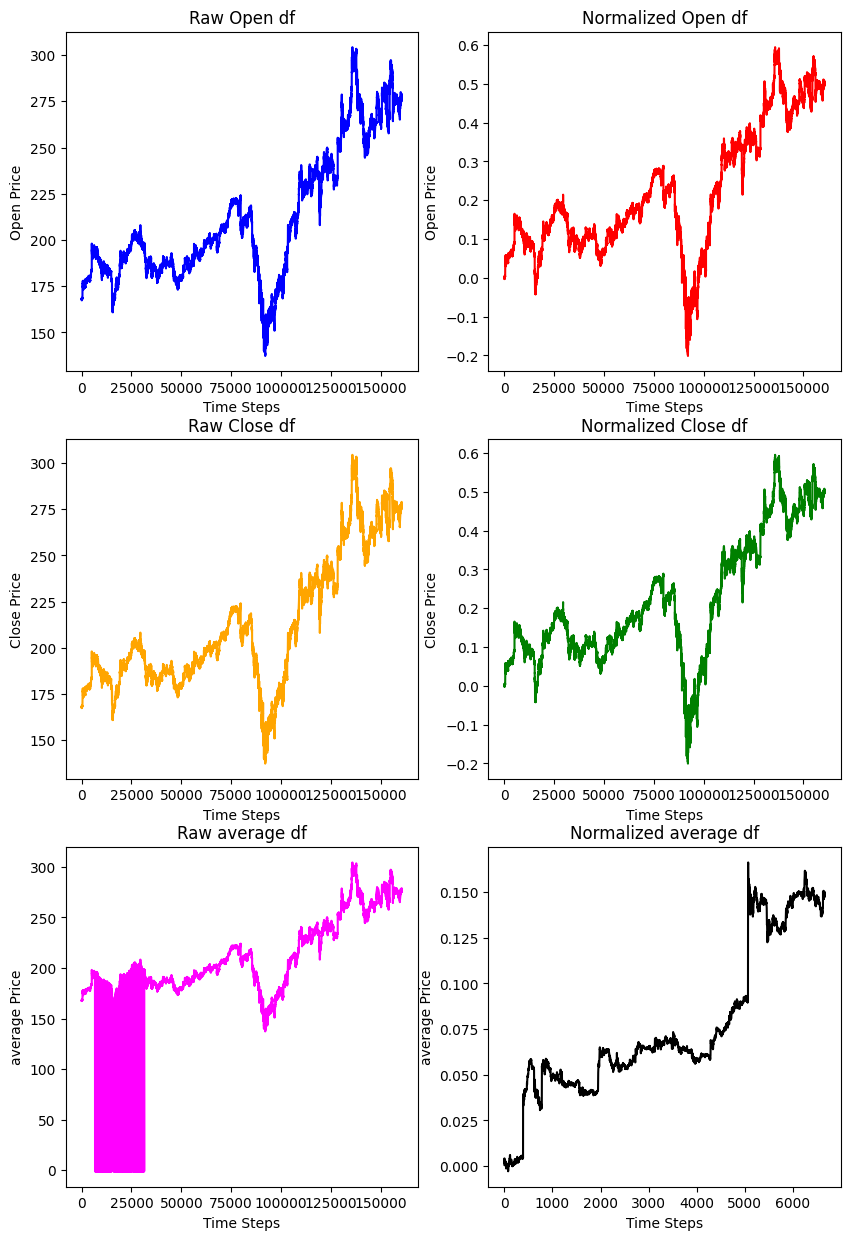

In [ ]:
fig = plt.figure(figsize=(10, 15))

plt.subplot(3, 2, 1)
plt.plot(open, color="blue")
plt.title("Raw Open df")
plt.xlabel("Time Steps")
plt.ylabel("Open Price")

plt.subplot(3, 2, 2)
plt.plot(open_csum_logreturn, color="red")
plt.title("Normalized Open df")
plt.xlabel("Time Steps")
plt.ylabel("Open Price")

plt.subplot(3, 2, 3)
plt.plot(close, color="orange")
plt.title("Raw Close df")
plt.xlabel("Time Steps")
plt.ylabel("Close Price")

plt.subplot(3, 2, 4)
plt.plot(close_csum_logreturn, color="green")
plt.title("Normalized Close df")
plt.xlabel("Time Steps")
plt.ylabel("Close Price")

plt.subplot(3, 2, 5)
plt.plot(average, color="magenta")
plt.title("Raw average df")
plt.xlabel("Time Steps")
plt.ylabel("average Price")

plt.subplot(3, 2, 6)
plt.plot(average_csum_logreturn, color="black")
plt.title("Normalized average df")
plt.xlabel("Time Steps")
plt.ylabel("average Price")

Plot shows the reduced scale of the closing prices

# 2. Model Definition

### 2.1. Positional Encoding Layer

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

### 2.2. Transformer Model

In [ ]:
class transformer(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super(transformer, self).__init__()
        self.model_type = "Transformer"

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if(self.src_mask is None or self.src_mask.size(0) != len(src)):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
        return mask

# 3. Utils Functions




### 3.1. Create Window Sequence

In [ ]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

### 3.2. Split Data
Split data into the train and testing set, prepared in windowed sequences and pass through GPU

In [ ]:
def get_data(data, split):

    series = data

    split = round(split * len(series))
    train_data = series[:split]
    test_data = series[split:]

    train_data = train_data.cumsum()

    # Training data augmentation, increase amplitude for the model to better generalize.(Scaling by 2 is aribitrary)
    # Similar to image transformation to allow model to train on wider data sets
    train_data = 2 * train_data

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data, input_window)
    train_sequence = train_sequence[:-output_window]

    test_data = create_inout_sequences(test_data, input_window)
    test_data = test_data[:-output_window]

    return train_sequence.to(device), test_data.to(device)

### 3.3. Split into training batches

In [ ]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return input, target

### 3.4. Training Function

In [ ]:
def train(train_data):
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if(batch % log_interval == 0 and batch > 0):
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print("| epoch {:3d} | {:5d}/{:5d} batches | "
                  "lr {:02.10f} | {:5.2f} ms | "
                  "loss {:5.7f}".format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

### 3.5. Evaluation Function

In [ ]:
def evaluate(eval_model, data_source):
    eval_model.eval()
    total_loss = 0.0
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            total_loss += len(data[0])* criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

### 3.6. Forecast Function

#### 3.6.1. for one time step from window sequence

In [ ]:
def model_forecast(model, seqence):
    model.eval()
    total_loss = 0.0
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)

    seq = np.pad(seqence, (0, 3), mode="constant", constant_values=(0, 0))
    seq = create_inout_sequences(seq, input_window)
    seq = seq[:-output_window].to(device)

    seq, _ = get_batch(seq, 0, 1)
    with torch.no_grad():
        for i in range(0, output_window):
            output = model(seq[-output_window:])
            seq = torch.cat((seq, output[-1:]))

    seq = seq.cpu().view(-1).numpy()

    return seq

#### 3.6.2. for entire sequence

In [ ]:
def forecast_seq(model, sequences):

    start_timer = time.time()
    model.eval()
    forecast_seq = torch.Tensor(0)
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1).cpu()), 0)
            actual = torch.cat((actual, target[-1].view(-1).cpu()), 0)
    timed = time.time()-start_timer
    print(f"{timed} sec")

    return forecast_seq, actual

# 4. Train Phase

### 4.1. Prepare data for train model

In [ ]:
train_data, val_data = get_data(close_logreturn, 0.6) # 60% train, 40% test split
model = transformer().to(device)

/tmp/ipython-input-219410700.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.FloatTensor(inout_seq)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


### 4.2. Set Model Parameters

In [ ]:
criterion = nn.MSELoss()
lr = 0.00005
epochs = 50

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

### 4.3. Training Loop

In [ ]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)

    if(epoch % epochs == 0): # Valid model after last training epoch
        val_loss = evaluate(model, val_data)
        print("-" * 80)
        print("| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}".format(epoch, (time.time() - epoch_start_time), val_loss))
        print("-" * 80)

    else:
        print("-" * 80)
        print("| end of epoch {:3d} | time: {:5.2f}s".format(epoch, (time.time() - epoch_start_time)))
        print("-" * 80)

    scheduler.step()


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:523: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


| epoch   1 |    77/  385 batches | lr 0.0000500000 | 23.75 ms | loss 0.0425384
| epoch   1 |   154/  385 batches | lr 0.0000500000 | 10.25 ms | loss 0.0166587
| epoch   1 |   231/  385 batches | lr 0.0000500000 | 10.19 ms | loss 0.0058587
| epoch   1 |   308/  385 batches | lr 0.0000500000 | 10.17 ms | loss 0.0038924
| epoch   1 |   385/  385 batches | lr 0.0000500000 | 10.23 ms | loss 0.0109699
--------------------------------------------------------------------------------
| end of epoch   1 | time:  4.97s
--------------------------------------------------------------------------------
| epoch   2 |    77/  385 batches | lr 0.0000451250 | 10.35 ms | loss 0.0057709
| epoch   2 |   154/  385 batches | lr 0.0000451250 | 10.22 ms | loss 0.0038492
| epoch   2 |   231/  385 batches | lr 0.0000451250 | 10.83 ms | loss 0.0026350
| epoch   2 |   308/  385 batches | lr 0.0000451250 | 11.23 ms | loss 0.0029495
| epoch   2 |   385/  385 batches | lr 0.0000451250 | 11.26 ms | loss 0.0078834
----

In [ ]:
test_result, truth = forecast_seq(model, val_data)

66.33482527732849 sec


# 5. Results

### 5.1. Plot forecasted sequence vs actual

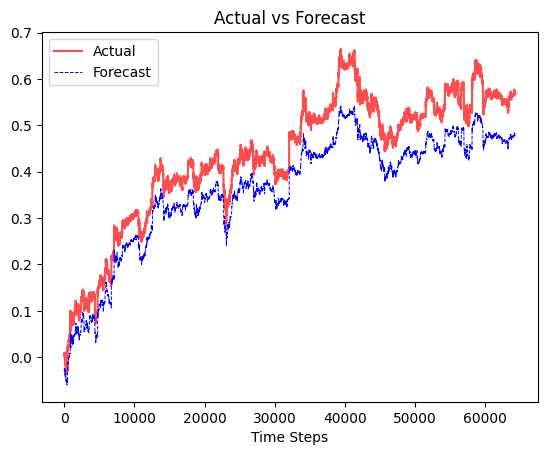

In [ ]:
plt.plot(truth, color="red", alpha=0.7)
plt.plot(test_result, color="blue", linestyle="dashed", linewidth=0.7)
plt.title("Actual vs Forecast")
plt.legend(["Actual", "Forecast"])
plt.xlabel("Time Steps")
plt.show()

### 5.2. Validate Model With Random Sequence

In [ ]:
r = np.random.randint(100000, 160000)
test_forecast = model_forecast(model, close_csum_logreturn[r: r+10]) # random 10 sequence length

print(f"forecast sequence: {test_forecast}\n")
print(f"Actual sequence: {close_csum_logreturn[r: r+11]}")

forecast sequence: [0.35772613 0.35891294 0.35932902 0.35962018 0.3598697  0.36024383
 0.3590586  0.35878807 0.3590378  0.359121   0.3019772 ]

Actual sequence: [0.35772611 0.35891293 0.35932903 0.35962019 0.35986969 0.36024383
 0.35905859 0.35878807 0.35903778 0.359121   0.35939143]


# 6. Save Model

In [ ]:
torch.save(model.state_dict(), "model/time_forecasting_transformer.pth")

# 7. Validation Phase

### 7.1. Load Model

In [ ]:
model_val = transformer()
model_val.load_state_dict(torch.load("model/time_forecasting_transformer.pth"))
model_val.to(device)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


transformer(
  (pos_encoder): PositionalEncoding()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=250, out_features=250, bias=True)
    )
    (linear1): Linear(in_features=250, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=250, bias=True)
    (norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=250, out_features=250, bias=True)
        )
        (linear1): Linear(in_features=250, out_features=2048, bias=True)
        (dropout): Dro

Testing model on Boeing stock from the same time period

### 7.2. Load Boeing Dataset and test model with this data

In [ ]:
df2 = pd.read_csv("data/boeing.csv")
close2 = df2["close"].fillna(method = "ffill")
close2 = np.array(close2)
logreturn2 = np.diff(np.log(close2))

/tmp/ipython-input-856978902.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close2 = df2["close"].fillna(method = "ffill")


In [ ]:
train_data2, val_data2 = get_data(logreturn2, 0.6)
test2_eval = evaluate(model_val, val_data2)
print(f"boeing test loss: {test2_eval :.5f}")

boeing test loss: 0.00226


66.33352303504944 sec


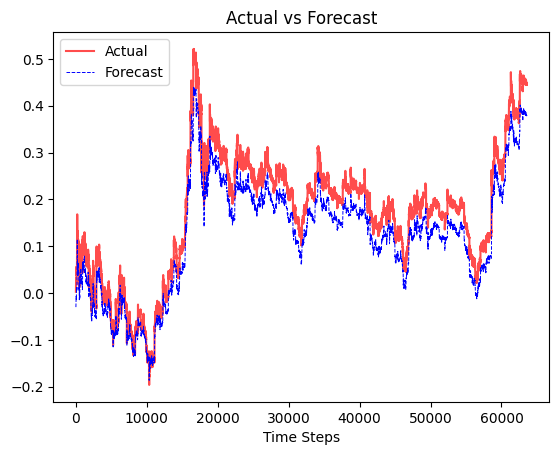

In [ ]:
test_result2, truth2 = forecast_seq(model_val, val_data2)

plt.plot(truth2, color="red", alpha=0.7)
plt.plot(test_result2, color="blue", linestyle="dashed", linewidth=0.7)
plt.title("Actual vs Forecast")
plt.legend(["Actual", "Forecast"])
plt.xlabel("Time Steps")
plt.show()

### 7.3. Load jp_morgan Dataset and test model with this data

In [ ]:
df3 = pd.read_csv("data/jp_morgan.csv")
close3 = df3["close"].fillna(method = "ffill")
close3 = np.array(close3)
logreturn3 = np.diff(np.log(close3))

/tmp/ipython-input-1316574195.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close3 = df3["close"].fillna(method = "ffill")


In [ ]:
train_data3, val_data3 = get_data(logreturn3, 0.6)
test3_eval = evaluate(model_val, val_data3)
print(f'jp morgan test loss: {test3_eval :.5f}')

jp morgan test loss: 0.00200


65.83794045448303 sec


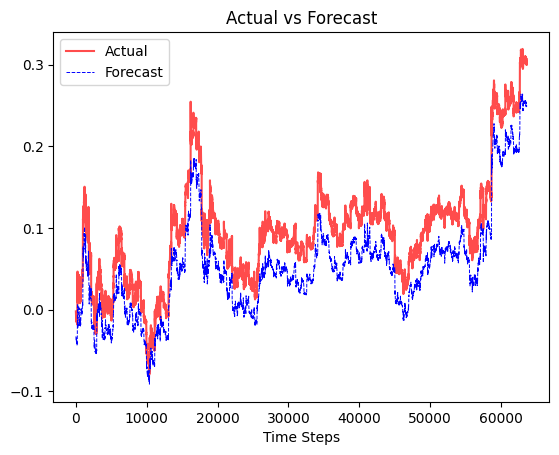

In [ ]:
test_result3, truth3 = forecast_seq(model_val, val_data3)

plt.plot(truth3, color="red", alpha=0.7)
plt.plot(test_result3, color="blue", linestyle="dashed", linewidth=0.7)
plt.title("Actual vs Forecast")
plt.legend(["Actual", "Forecast"])
plt.xlabel("Time Steps")
plt.show()